# Significance - why does it matter?

In [1]:
# standard imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

Here we will interactively demonstrate where quantifying significance can be important. We'll again link this to our coursework problem, though the ideas and techniques are much more general. **You will need a cross correlation code ready (see earlier notebooks) to run this code. We'll still show plots generated using my solution to earlier notebooks, but you won't be able to run this yourself (or attempt the exercises) without such a function ready**.

## Preparing code to add signals to data

To illustrate this we first need to define a code that will add signals to data. The code is below, it is not important for this lesson to understand what it is doing, but it's not using anything we haven't taught. The function takes one parameter "signal_loudness", which we will determine how loud the signal is with respect to the noise. There is also a random_seed key-word argument. Changing this will generate a different random realisation of noise. We also have sample_rate and length_of_data as key-word arguments. We won't use these, but provide them for flexibility if needed. There are two further key-word arguments, signal_gaussian_width and signal_chirpiness, which determine the parameters of the signal being added.

In [23]:
def make_signal_and_data(
    signal_loudness,
    random_seed=21,
    sample_rate = 32, # 32 samples per second
    length_of_data = 128, # 128 seconds worth of data. MUST BE A MULTIPLE OF 8!
    signal_gaussian_width = 1.,
    signal_chirpiness = 1.,
):

    # Some settings for the data
    num_data_samples = length_of_data*sample_rate # 128 seconds worth of data
    times = np.arange(num_data_samples) / sample_rate

    # Make the signal
    signal_inst_frequency = 2. + signal_chirpiness*np.sin(2 * np.pi * 0.1 * times)
    phases = [0]
    for i in range(1,len(times)):
        phases.append(phases[-1] + 2 * np.pi * signal_inst_frequency[i] * 1./sample_rate)
    signal = np.sin(phases)
    gaussian = np.exp( - (times - 64)**2 / (2 * signal_gaussian_width))
    signal = gaussian * np.sin(phases)
    # This takes a quarter of the signal (centered on the peak) to add to the data.
    # The signal should be 0, or close to it, outside of this period.
    signal = signal[length_of_data*3//8 * sample_rate:length_of_data*5//8 * sample_rate]

    # Make the noise, and add a signal to the noise at an unknown spot
    # Set seed so we get the same dataset!
    np.random.seed(random_seed)
    noise = np.random.normal(size=[num_data_samples])
    rndi = np.random.randint(0,sample_rate*(length_of_data*3//4))
    data = noise
    data[rndi:rndi+len(signal)] += signal*signal_loudness
    
    return data, signal

## No signal in the data

Now let's generate some noise with *no* signal and cross-correlate the noise with the signal that wasn't added.
This should just be noisy.

In [24]:
signal_loudness = 0
data, signal = make_signal_and_data(signal_loudness)

To cross-correlate you'll now need your cross-correlation function. **REPLACE THE LINE BELOW WITH YOUR CROSS-CORRELATION FUNCTION FROM EARLIER EXERCISES**

In [14]:
from crosscorr_utils import compute_cross_correlation

In [25]:
cc = compute_cross_correlation(signal, data)

Text(0, 0.5, 'Cross correlation')

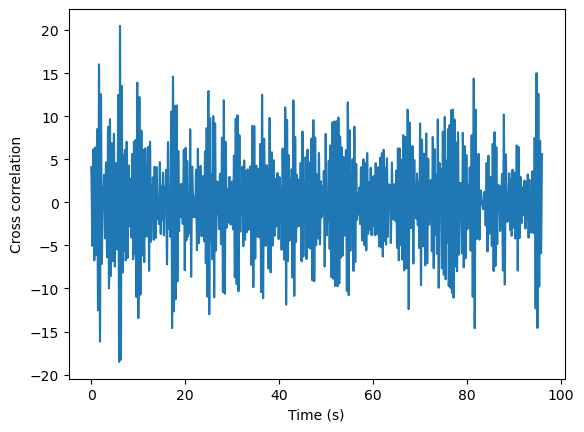

In [26]:
plt.plot(np.arange(32*96) / 32, cc)
plt.xlabel('Time (s)')
plt.ylabel('Cross correlation')

##  Loud signal in the data

For the second example we add a loud signal to the data and cross-correlate. Now it should be *very* clear a) that there is a signal and b) where the signal is in the dataset.

Text(0, 0.5, 'Cross correlation')

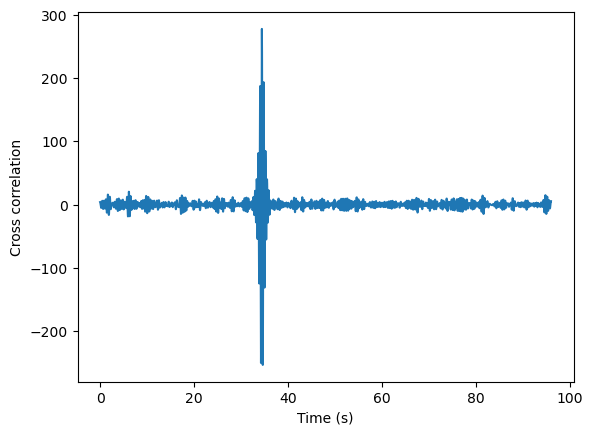

In [28]:
signal_loudness = 10
data, signal = make_signal_and_data(signal_loudness)
cc = compute_cross_correlation(signal, data)
plt.plot(np.arange(32*96) / 32, cc)
plt.xlabel('Time (s)')
plt.ylabel('Cross correlation')

## Weak signal

But what if the signal is in the middle? Let's now try something where there *is* a signal but the amplitude is much smaller than the case above.

Text(0, 0.5, 'Cross correlation')

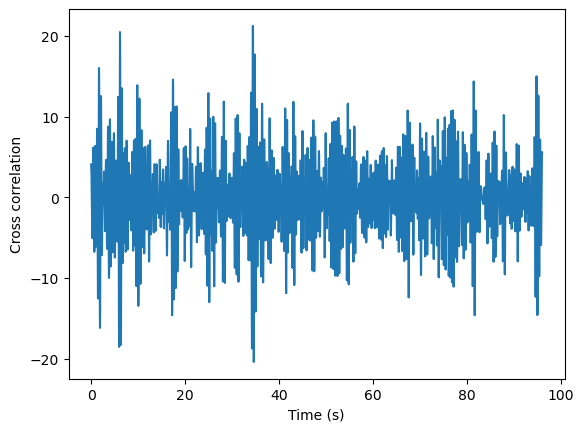

In [29]:
signal_loudness = 0.9
data, signal = make_signal_and_data(signal_loudness)
cc = compute_cross_correlation(signal, data)
plt.plot(np.arange(32*96) / 32, cc)
plt.xlabel('Time (s)')
plt.ylabel('Cross correlation')

Now can you see where the signal is? (HINT: We didn't change the random seed, so it's in the same position as the loud signal). But if you didn't know that would you be sure that this was real or not?

One could try to determine a threshold at which we confidently declare something is real, but where does that threshold lie? Clearly a value of 300 is not possible from noise, but a value of 20 is not so unlikely, what about 30? Where best to set that threshold?

Indeed, do we need to set a threshold at all? Why not quantify how likely it is that the event is real. In this notebook we will learn how to compute a false-alarm rate, which is the rate at which noise would produce an event as loud (or louder) than what you've observed. Equivalently this can be translated to a "p-value", the probability that you would get at least one event at least as loud as what you saw, given the experiment you did.

Note that this is not the same as the probability that it is real. Bayesian statistics has more to say on this problem ... A simple example is the following: Consider that I am rolling a 6-sided dice, sending the number to another experimenter, but noise is affecting the number that experimemnter receives. If the experimenter receives the number "7" they would know that a 7 is not possible and most likely I rolled a 6 (but possibly it was a 5) .. However, if they receive 5 then it is most likely that I rolled a 5 (though it could have been a 6, or a 4, or ...). We will not consider Bayesian statistics here, and leave this for another lecture.